#### Quick look at the data

In [1]:
import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import geopandas
from argopy import DataFetcher as ArgoDataFetcher

In [2]:
plt.rc('font', size=12)

### Argo data

Tried to load in some Argo data to have a look at but this method did not seem to work.

In [4]:
argo_loader = ArgoDataFetcher()

In [5]:
argo_loader

<datafetcher.erddap> 'No access point initialised'
Available access points: float, profile, region
Performances: cache=False, parallel=False
User mode: standard
Dataset: phy

In [18]:
box = [-180, 180, -60, -45, 0, 10, '2019-01','2019-02']

In [20]:
loader_par = ArgoDataFetcher(src='erddap', parallel=True, progress=True).region(box)

In [21]:
loader_par

<datafetcher.erddap>
Name: Ifremer erddap Argo data fetcher for a space/time region
API: https://erddap.ifremer.fr/erddap/
Domain: [x=-180.00/180.00; y=-60.00/-4 ... 10.0; t=2019-01-01/2019-02-01]
Performances: cache=False, parallel=True
User mode: standard
Dataset: phy

In [22]:
%%time
ds = loader_par.to_xarray()

100%|██████████| 18/18 [01:00<00:00,  3.37s/it]


ValueError: Errors happened with all URLs, this could be due to an internal impossibility to read returned content.

In [17]:
ds = argo_loader.region([-180, 180, -60, -45, 0, 100, '2019-01-01','2019-02-25']).to_xarray()

FSTimeoutError: 

In [33]:
# ds_argo = argo_loader.region([lonmin, lonmax, latmin, latmax, pressure_min, pressure_max, '2019-01', '2019-02']).to_xarray()

### Saildrone data

Circumpolar track around the Southern Ocean from 2019.

In [3]:
#non-adcp and adcp data
nonadcp_url = '/home/jovyan/OHW22_proj_front_finder/data/saildrones/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1620360815446.nc'
adcp_url = '/home/jovyan/OHW22_proj_front_finder/data/saildrones/saildrone-gen_5-antarctica_circumnavigation_2019-sd1020-20190119T040000-20190803T043000-1_minutes-v1.1597092482498.nc'


In [4]:
# open data files with xarray 
ds = xr.open_dataset(nonadcp_url)
adcp = xr.open_dataset(adcp_url)

In [5]:
# get rid of trajectory dimension
ds = ds.squeeze()
adcp = adcp.squeeze()

In [8]:
# reduce to variables we want
variables = [
    'TEMP_CTD_RBR_STDDEV',
    'TEMP_CTD_RBR_MEAN',
    'SAL_RBR_MEAN',
    'SAL_RBR_STDDEV',
    'O2_CONC_AANDERAA_MEAN',
    'O2_CONC_AANDERAA_STDDEV',
    'CHLOR_RBR_MEAN',
    'CHLOR_RBR_STDDEV']

variables_adcp = ['vel_east',
                  'vel_north',
                  'vel_up']

subset = ds[variables]
adcp_subset = adcp[variables_adcp]

In [13]:
# calculate potential density and add to dataset
# note we are not using conservative temp - this shouldnt matter much since we are at surface
# (i.e. no pressure effects)
import gsw
subset['sigma0'] = gsw.density.sigma0(subset['SAL_RBR_MEAN'],subset['TEMP_CTD_RBR_MEAN'])

#### plots

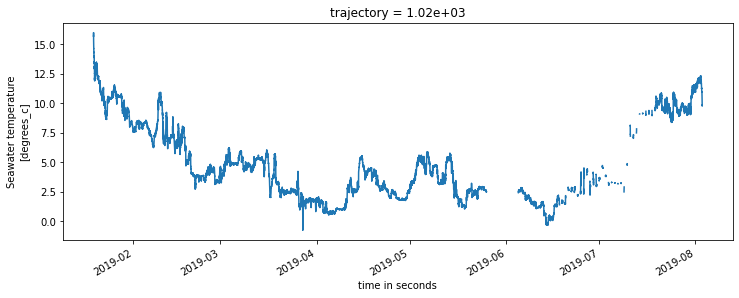

In [17]:
figure = plt.figure(figsize=(12,4))
subset.TEMP_CTD_RBR_MEAN.plot(x='time')

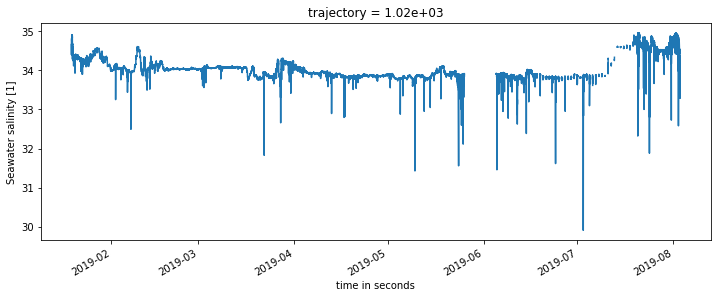

In [18]:
figure = plt.figure(figsize=(12,4))
subset.SAL_RBR_MEAN.plot(x='time')

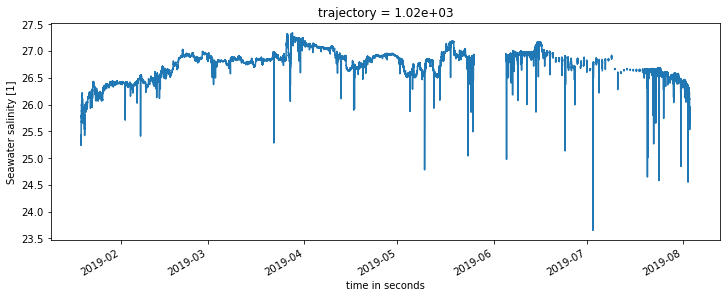

In [19]:
figure = plt.figure(figsize=(12,4))
subset.sigma0.plot(x='time')

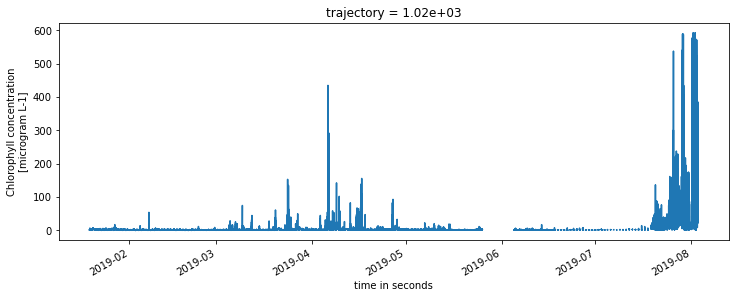

In [20]:
figure = plt.figure(figsize=(12,4))
subset.CHLOR_RBR_MEAN.plot(x='time')

In [28]:
# there are clearly nans in the non-adcp data, lets drop those 
subset = subset.dropna(dim='obs')

In [29]:
subset

<xarray.Dataset>
Dimensions:                  (obs: 229137)
Coordinates:
    latitude                 (obs) float64 ...
    longitude                (obs) float64 ...
    time                     (obs) datetime64[ns] ...
    trajectory               float32 1.02e+03
Dimensions without coordinates: obs
Data variables:
    TEMP_CTD_RBR_STDDEV      (obs) float64 0.002 0.002 0.003 ... 0.007 0.018
    TEMP_CTD_RBR_MEAN        (obs) float64 15.68 15.67 15.68 ... 9.868 9.861
    SAL_RBR_MEAN             (obs) float64 34.66 34.68 34.67 ... 33.38 33.43
    SAL_RBR_STDDEV           (obs) float64 0.003 0.002 0.003 ... 0.026 0.036
    O2_CONC_AANDERAA_MEAN    (obs) float64 293.0 293.1 292.7 ... 329.0 329.2
    O2_CONC_AANDERAA_STDDEV  (obs) float64 0.64 0.04 0.05 ... 0.06 0.07 0.09
    CHLOR_RBR_MEAN           (obs) float64 1.505 1.534 1.453 ... 69.34 52.6
    CHLOR_RBR_STDDEV         (obs) float64 0.0268 0.1127 0.0275 ... 1.73 1.385
    sigma0                   (obs) float64 25.43 25.45 25.44 ... 25.6 25.63
Attributes: (12/38)
    title:                     Antarctica Circumnavigation Surface Data
    summary:                   This data set was collected from the first Sai...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.3
    featureType:               trajectory
    ...                        ...
    geospatial_lat_min:        -60.9862208
    geospatial_lat_max:        -46.4277568
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -179.9986816
    geospatial_lon_max:        179.9997312
    geospatial_lon_units:      degrees_east

#### calculate distance between points 

In [30]:
# convert lat/lon to km to get distance between points 
theta = subset.latitude*np.pi/180

dx = 111*subset.longitude/np.cos(theta)
dy = 111*subset.latitude

In [41]:
subset['dx'] = dx
subset['dy'] = dy

In [42]:
subset

<xarray.Dataset>
Dimensions:                  (obs: 229137)
Coordinates:
    latitude                 (obs) float64 -46.68 -46.68 -46.68 ... -46.6 -46.6
    longitude                (obs) float64 168.5 168.5 168.5 ... 168.4 168.4
    time                     (obs) datetime64[ns] ...
    trajectory               float32 1.02e+03
Dimensions without coordinates: obs
Data variables:
    TEMP_CTD_RBR_STDDEV      (obs) float64 0.002 0.002 0.003 ... 0.007 0.018
    TEMP_CTD_RBR_MEAN        (obs) float64 15.68 15.67 15.68 ... 9.868 9.861
    SAL_RBR_MEAN             (obs) float64 34.66 34.68 34.67 ... 33.38 33.43
    SAL_RBR_STDDEV           (obs) float64 0.003 0.002 0.003 ... 0.026 0.036
    O2_CONC_AANDERAA_MEAN    (obs) float64 293.0 293.1 292.7 ... 329.0 329.2
    O2_CONC_AANDERAA_STDDEV  (obs) float64 0.64 0.04 0.05 ... 0.06 0.07 0.09
    CHLOR_RBR_MEAN           (obs) float64 1.505 1.534 1.453 ... 69.34 52.6
    CHLOR_RBR_STDDEV         (obs) float64 0.0268 0.1127 0.0275 ... 1.73 1.385
    sigma0                   (obs) float64 25.43 25.45 25.44 ... 25.6 25.63
    dx                       (obs) float64 2.727e+04 2.727e+04 ... 2.72e+04
    dy                       (obs) float64 -5.182e+03 -5.182e+03 ... -5.172e+03
Attributes: (12/38)
    title:                     Antarctica Circumnavigation Surface Data
    summary:                   This data set was collected from the first Sai...
    ncei_template_version:     NCEI_NetCDF_Trajectory_Template_v2.0
    Conventions:               CF-1.6, ACDD-1.3
    netcdf_version:            4.6.3
    featureType:               trajectory
    ...                        ...
    geospatial_lat_min:        -60.9862208
    geospatial_lat_max:        -46.4277568
    geospatial_lat_units:      degrees_north
    geospatial_lon_min:        -179.9986816
    geospatial_lon_max:        179.9997312
    geospatial_lon_units:      degrees_east

In [51]:
# swap obs with time dimension 
subset = subset.swap_dims({'obs':'time'})

In [57]:
# calculate relative distance between points 
distance = np.sqrt(subset.dx**2 + subset.dy**2)

In [60]:
# add to dataset 
subset['distance'] = distance

In [62]:
# possibly resample??
# subset.resample(time='5MIN').mean()

<xarray.DataArray 'distance' ()>
array(-0.19048594)
Coordinates:
    trajectory  float32 1.02e+03

#### next steps:
1. think about thresholds for the different variables 
2. test differentiating variables relative to a threshold and max distance between points 
3. make function for getting gradients that will include inputs of a certain variable (e.g. temp, sal, density), resolution (i.e. resample the data to get larger scales), and returns the gradients 